# CSS repulsive potential generation (2-body)

Input: DFT_DB.db 

Output: CCS parameters and fit of predicted energies vs. those in the DFT database 



In [1]:
import os, sys, warnings
import json
import itertools as it
from collections import OrderedDict, defaultdict
import numpy as np
from ase import Atoms
from ase import io
from ase.calculators.neighborlist import NeighborList
import ase.db as db
from tqdm import tqdm 
from ccs.scripts.ccs_fetch import ccs_fetch as ccs_fetch
from ccs.fitting.main import twp_fit as ccs_fit

from ccs.common.exceptions import ScriptError 
from ccs.ase_calculator.ccs_ase_calculator import CCS

base_dir=os.getcwd()
os.chdir(base_dir)
print('Base dir is:', base_dir)
warnings.filterwarnings('ignore')


/Users/tjams20/opt/anaconda3/envs/CCS/lib/python3.9/site-packages/ase/calculators/neighborlist.py:5: UserWarning: Moved to ase.neighborlist
  warnings.warn('Moved to ase.neighborlist')


Base dir is: /Users/tjams20/Documents/repos/CCS/examples


In [2]:
#generate data generates trainingset in the format for CCS (structures.json)
cwd = os.getcwd()
if not os.path.isdir(cwd+"/CCS/"):
    os.mkdir(cwd+"/CCS/")
os.chdir(cwd+"/CCS/")

### Cleaning up old files

if os.path.isfile('CCS_DB.db'):
    os.remove('CCS_DB.db')

if os.path.isfile('ccs.spl'):
    os.remove('ccs.spl')

In [3]:
#generate data generates trainingset in the format for CCS (structures.json)

ccs_fetch(mode='CCS', R_c=6.0, Ns='all', DFT_DB='../DFT_DB.db', DFTB_DB='../DFT_DB.db')


100%|█| 999/999 [00:0


In [4]:
#DEFINE INPUT

input={
    "General": {
        "interface": "CCS"
    },
    "Twobody": {
                "Xx-Xx": {
                        "Rcut": 6.0,
                        "Resolution": 0.05,
                        "Swtype": "rep"
                }
        }
}
#SAVE TO FILE
with open('input.json', 'w') as f:
    json.dump(input, f, indent=8)
    
#RUN FIT
ccs_fit("input.json")

Generating one-body information from training-set.
    Added elements:  O Li C H
Generating two-body potentials from one-body information.
    Adding pair: O-O
    Adding pair: Li-O
    Did not add pair: Li-O
    Adding pair: Li-Li
    Did not add pair: Li-Li
    Adding pair: C-O
    Did not add pair: C-O
    Adding pair: C-Li
    Did not add pair: C-Li
    Adding pair: C-C
    Did not add pair: C-C
    Adding pair: C-H
    Did not add pair: C-H
    Adding pair: H-O
    Did not add pair: H-O
    Adding pair: H-Li
    Did not add pair: H-Li
    Adding pair: H-H
    Did not add pair: H-H


Finding optimum switc


## Analysis

In [5]:
struct=db.connect("../DFT_DB.db")
db_ccs=db.connect("CCS_DB.db")

with open('CCS_params.json', 'r') as f:
    CCS_params = json.load(f)

for row in tqdm(struct.select(), total=len(struct)):  
    structure=row.toatoms()
    structure.calc=CCS(CCS_params=CCS_params)
    structure.get_potential_energy()
    structure.get_forces()
    db_ccs.write(structure,key=row.key,CCS=True)

100%|█| 999/999 [00:1


In [6]:
#Read Data

dbname_DFT='../DFT_DB.db'
dbname_CCS='CCS_DB.db'
db_ccs=db.connect(dbname_CCS)
db_dft=db.connect(dbname_DFT)
epred=[];edft=[]; eccs=[];
for row in tqdm(db_dft.select(), total=len(db_dft)):
    structure=row.toatoms()
    natoms=len(structure.get_atomic_numbers())
    id=str(row.key)
    eccs.append(db_ccs.get('key='+id).energy/natoms)
    edft.append(db_dft.get('key='+id).energy/natoms) 


100%|█| 999/999 [00:0


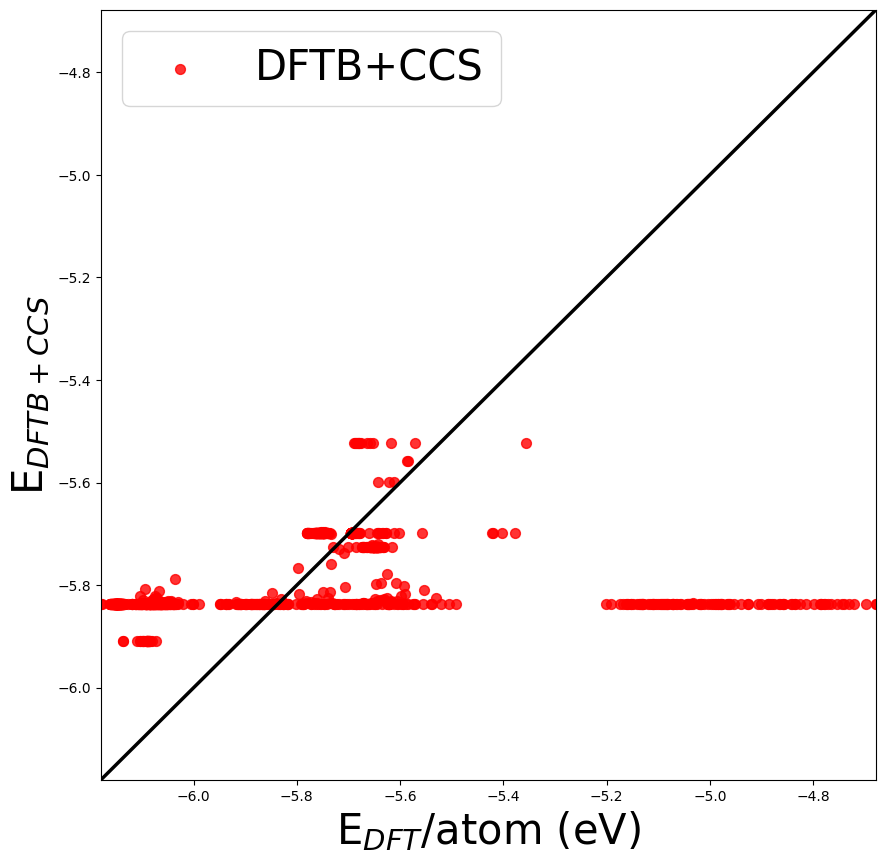

In [7]:
#plot Energies

import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
plt.scatter(edft, eccs, s=50, alpha=0.8, color='r')

plt.plot([np.min(edft),np.max(edft)], [np.min(edft),np.max(edft)], 'k-', lw=2.5)
plt.legend(labels=["DFTB+CCS"], fontsize=30 )
plt.xlabel('E$_{DFT}$/atom (eV)',fontsize=30)
plt.ylabel('E$_{DFTB+CCS}$',fontsize=30)
plt.xlim(np.min(edft),np.max(edft))
plt.ylim(np.min(edft),np.max(edft))
plt.savefig('DFTvsDFTB+CCS.png')
plt.show()